
Rosenbrock: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rosenbrock'
n_test = 500
eps = 1e-06

util = 'ERM'
util_t = 'tERM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3
cov_func = squaredExponential()


In [4]:
### Objective function:

if func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def objfunc(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Acquisition function:

class Acquisition(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM,
            'tERM': self.tERM
        }

        self.f = mode_dict[mode]
    
    def ERM(self, y_global_orig, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]

    def tERM(self, y_global_orig, mean, std, nu=df):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)


In [8]:
n_start = n_start_AcqFunc
inverseRev = 1


In [9]:
## GPGO_multi: Gaussian

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverseRev * self.GP.y[init_eval], inverseRev * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverseRev * self.GP.y[-1])
        curr_best = str(inverseRev * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverseRev * self.GP.y[init_eval], inverseRev * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverseRev * self.GP.y[-1])
        curr_best = str(inverseRev * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_9 = 9


In [12]:
### ESTIMATED GP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=opt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition(util), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [ 1.43946618 -0.01529201]	 -435.89817117880875	 -132.4681822844375	 -135.04317445934976


In [13]:
### ESTIMATED STP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition(util_t), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [0.77016432 0.11390309]	 -23.020879298271552	 -23.020879298271552	 -515.2058292116615


In [14]:
gp_9.start_points_arr


array([[ 1.2441181 ,  1.97983948],
       [-1.35316989,  0.08636298],
       [ 1.82483934,  0.61251774],
       [ 1.47796756,  1.92858527],
       [-1.28802125, -1.05219819],
       [ 1.52944985,  1.66411173],
       [ 1.05790663, -0.6270896 ],
       [-0.14936181,  0.45276259],
       [-0.01523008, -0.09021844],
       [-0.26396482,  1.51719238],
       [-1.28057898,  0.76871309],
       [ 0.8336555 ,  1.74161952],
       [-1.88639307,  0.60259006],
       [ 0.56546912, -0.15688637],
       [-1.8306686 , -1.8900135 ],
       [-1.35359933,  1.20646815],
       [-1.38196563, -1.47972629],
       [-0.60245216, -0.06349433],
       [ 0.80992823,  1.23353674],
       [-0.95529215,  1.67721455]])

In [15]:
stp_9.start_points_arr


array([[ 1.2441181 ,  1.97983948],
       [-1.35316989,  0.08636298],
       [ 1.82483934,  0.61251774],
       [ 1.47796756,  1.92858527],
       [-1.28802125, -1.05219819],
       [ 1.52944985,  1.66411173],
       [ 1.05790663, -0.6270896 ],
       [-0.14936181,  0.45276259],
       [-0.01523008, -0.09021844],
       [-0.26396482,  1.51719238],
       [-1.28057898,  0.76871309],
       [ 0.8336555 ,  1.74161952],
       [-1.88639307,  0.60259006],
       [ 0.56546912, -0.15688637],
       [-1.8306686 , -1.8900135 ],
       [-1.35359933,  1.20646815],
       [-1.38196563, -1.47972629],
       [-0.60245216, -0.06349433],
       [ 0.80992823,  1.23353674],
       [-0.95529215,  1.67721455]])

In [16]:
np.sum((stp_9.start_points_arr - gp_9.start_points_arr)**2)


0.0

In [17]:
np.round(gp_9.f_best, 5), np.argmin(gp_9.f_best)


(array([-135.04317,   -0.     , -135.04317, -135.04317,   -0.     ,
        -135.04317, -135.04317,   -0.     ,   -0.     , -135.04317,
          -0.     , -135.04317,   -0.     , -135.04317,   -0.     ,
          -0.     ,   -0.     ,   -0.     , -135.04317, -135.04317]), 19)

In [18]:
min(gp_9.f_best), np.round(max(gp_9.f_best), 4)


(-135.04317445934976, -0.0)

In [19]:
gp_9.x_best[np.argmin(gp_9.f_best)], gp_9.best


(array([ 1.43946618, -0.01529201]), array([ 1.43946618, -0.01529201]))

In [20]:
np.round(stp_9.f_best, 5), np.argmin(stp_9.f_best)


(array([-515.20583, -515.20583, -515.20583, -515.20583, -459.84922,
        -515.20583, -515.20583, -515.20583, -515.20583, -515.20583,
        -515.20583, -515.20583, -515.20583, -515.20583, -171.36415,
        -515.20583, -459.84922, -515.20583, -515.20583, -515.20583]), 3)

In [21]:
min(stp_9.f_best), np.round(max(stp_9.f_best), 4)


(-515.2058292116615, -171.3642)

In [22]:
stp_9.x_best[np.argmin(stp_9.f_best)], stp_9.best


(array([0.77016432, 0.11390309]), array([0.77016432, 0.11390309]))

In [23]:
np.sum((stp_9.f_best - gp_9.f_best)**2)


3755584.0464321454

In [24]:
stp_9.x_best


array([[ 0.77016446,  0.11390334],
       [ 0.77016472,  0.11390389],
       [ 0.77016426,  0.11390296],
       [ 0.77016432,  0.11390309],
       [ 2.048     , -2.048     ],
       [ 0.77016424,  0.11390333],
       [ 0.77016258,  0.11390403],
       [ 0.77016411,  0.11390312],
       [ 0.77016452,  0.11390277],
       [ 0.77016434,  0.11390318],
       [ 0.77016443,  0.11390298],
       [ 0.77016448,  0.1139031 ],
       [ 0.77016433,  0.11390317],
       [ 0.77016428,  0.11390322],
       [-2.048     , -2.048     ],
       [ 0.7701675 ,  0.11389834],
       [ 2.048     , -2.048     ],
       [ 0.77016432,  0.11390267],
       [ 0.77016389,  0.11390263],
       [ 0.77016492,  0.11390307]])

In [25]:
np.sum((stp_9.x_best - stp_9.start_points_arr)**2)


74.9152610505877

In [26]:
gp_9.x_best


array([[ 1.43946648, -0.01529104],
       [-1.35316989,  0.08636298],
       [ 1.43946585, -0.01529417],
       [ 1.43946636, -0.0152922 ],
       [-1.28802125, -1.05219819],
       [ 1.43946629, -0.01529146],
       [ 1.43946707, -0.01529133],
       [-0.14936181,  0.45276259],
       [-0.01523008, -0.09021844],
       [ 1.43946487, -0.01528825],
       [-1.28057898,  0.76871309],
       [ 1.43946289, -0.01526743],
       [-1.88639307,  0.60259006],
       [ 1.43945734, -0.01529863],
       [-1.8306686 , -1.8900135 ],
       [-1.35359933,  1.20646815],
       [-1.38196563, -1.47972629],
       [-0.60245216, -0.06349433],
       [ 1.43946633, -0.01529164],
       [ 1.43946618, -0.01529201]])

In [27]:
np.sum((gp_9.x_best - gp_9.start_points_arr)**2)


31.7329497038778

In [28]:
np.sum((stp_9.x_best - gp_9.x_best)**2)


54.60524382420397

In [29]:
a = gp_9.best[0]
b = gp_9.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


435.89817117880875

In [30]:
a = stp_9.best[0]
b = stp_9.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


23.020879298271552

In [31]:
xBest0 = 0.0898
xBest1 = -0.7126

xBest = [xBest0, xBest1]
xBest


[0.0898, -0.7126]

In [32]:
def check(x):
  a = x[:,0]
  b = x[:,1] 
  for i in range(0, len(a) - 1):
    res = (a - xBest0)**2 + (b - xBest1)**2 
    return np.sum(res)

check(gp_9.x_best), check(stp_9.x_best)


(53.829396155322854, 37.071210284174605)

In [33]:
np.std(gp_9.x_best), np.std(stp_9.x_best)


(1.0761734903617375, 0.9011332348272715)

In [34]:
np.mean(gp_9.x_best), np.mean(stp_9.x_best)


(0.04103891986109145, 0.27332861487818666)

In [35]:
gp_9_20rms = pd.Series(np.round(gp_9.f_best, 2)).value_counts(sort=True)
gp_9_20rms_df = pd.DataFrame({'Frequency':gp_9_20rms.values,'GP ERM':gp_9_20rms.index})
gp_9_20rms_df


,Frequency,GP ERM
0,10,-135.04
1,10,-0.00


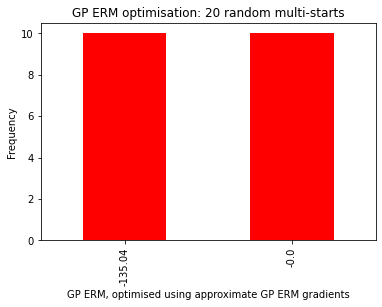

In [36]:
ax = gp_9_20rms.plot.bar(title="GP ERM optimisation: 20 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [37]:
stp_9_20rms = pd.Series(np.round(stp_9.f_best, 2)).value_counts(sort=True)
stp_9_20rms_df = pd.DataFrame({'Frequency':stp_9_20rms.values,'STP ERM':stp_9_20rms.index})
stp_9_20rms_df


,Frequency,STP ERM
0,17,-515.21
1,2,-459.85
2,1,-171.36


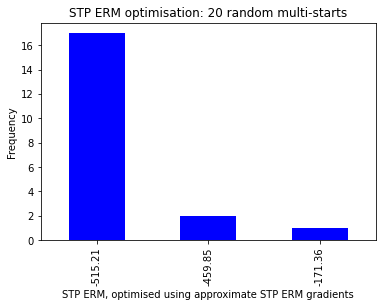

In [38]:
ax = stp_9_20rms.plot.bar(title="STP ERM optimisation: 20 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="blue")


In [39]:
n_start = 50


In [40]:
### ESTIMATED GP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_gp_9_50rms = GaussianProcess(cov_func, optimize=opt)

gp_9_50rms = GPGO_multi(surrogate_gp_9_50rms, Acquisition(util), objfunc, param)
gp_9_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [ 1.4394663 -0.0152918]	 -435.8982343544684	 -132.4681822844375	 -135.04317445934979


In [41]:
### ESTIMATED STP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_stp_9_50rms = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9_50rms = GPGO_multi_STP(surrogate_stp_9_50rms, Acquisition(util_t), objfunc, param)
stp_9_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [0.77016432 0.11390309]	 -23.020879298271552	 -23.020879298271552	 -515.2058292116615


In [42]:
gp_9_50rms = pd.Series(np.round(gp_9_50rms.f_best, 2)).value_counts(sort=True)
gp_9_50rms_df = pd.DataFrame({'Frequency':gp_9_50rms.values,'GP ERM':gp_9_50rms.index})
gp_9_50rms_df


,Frequency,GP ERM
0,24,-135.04
1,24,-0.00
2,2,-128.17


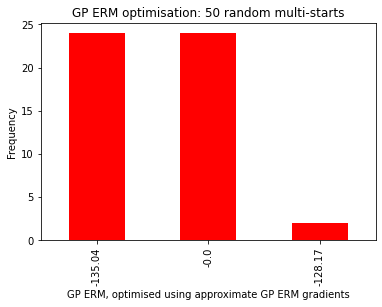

In [43]:
ax = gp_9_50rms.plot.bar(title="GP ERM optimisation: 50 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [44]:
stp_9_50rms = pd.Series(np.round(stp_9_50rms.f_best, 2)).value_counts(sort=True)
stp_9_50rms_df = pd.DataFrame({'Frequency':stp_9_50rms.values,'STP ERM':stp_9_50rms.index})
stp_9_50rms_df


,Frequency,STP ERM
0,43,-515.21
1,5,-459.85
2,2,-171.36


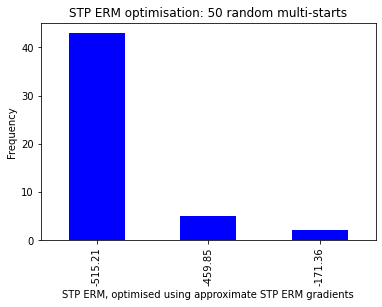

In [45]:
ax = stp_9_50rms.plot.bar(title="STP ERM optimisation: 50 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="blue")


In [46]:
n_start = 100


In [47]:
### ESTIMATED GP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_gp_9_100rms = GaussianProcess(cov_func, optimize=opt)

gp_9_100rms = GPGO_multi(surrogate_gp_9_100rms, Acquisition(util), objfunc, param)
gp_9_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [ 1.4394662  -0.01529186]	 -435.89813473775206	 -132.4681822844375	 -135.04317445934993


In [48]:
### ESTIMATED STP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_stp_9_100rms = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9_100rms = GPGO_multi_STP(surrogate_stp_9_100rms, Acquisition(util_t), objfunc, param)
stp_9_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 -1620.5592513107108	 -132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 -226.0751192637302	 -132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 -1096.1928272344956	 -132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 -132.4681822844375	 -132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 -1257.2172959284223	 -132.4681822844375	    
1	 [0.77016432 0.11390309]	 -23.020879298271552	 -23.020879298271552	 -515.2058292116615


In [49]:
gp_9_100rms = pd.Series(np.round(gp_9_100rms.f_best, 2)).value_counts(sort=True)
gp_9_100rms_df = pd.DataFrame({'Frequency':gp_9_100rms.values,'GP ERM':gp_9_100rms.index})
gp_9_100rms_df


,Frequency,GP ERM
0,53,-135.04
1,45,-0.00
2,2,-128.17


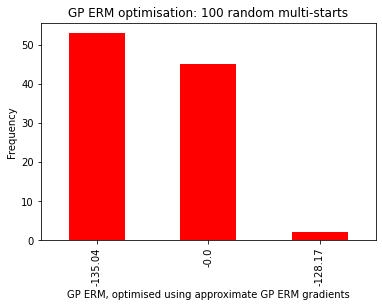

In [50]:
ax = gp_9_100rms.plot.bar(title="GP ERM optimisation: 100 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [51]:
stp_9_100rms = pd.Series(np.round(stp_9_100rms.f_best, 2)).value_counts(sort=True)
stp_9_100rms_df = pd.DataFrame({'Frequency':stp_9_100rms.values,'STP ERM':stp_9_100rms.index})
stp_9_100rms_df


,Frequency,STP ERM
0,87,-515.21
1,8,-459.85
2,5,-171.36


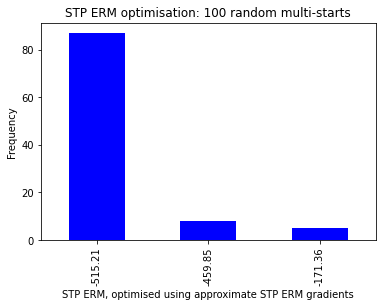

In [52]:
ax = stp_9_100rms.plot.bar(title="STP ERM optimisation: 100 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="blue")


In [53]:
print(gp_9_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-135.04 &  10 \\
-0.00   &  10 \\
\bottomrule
\end{tabular}



In [54]:
print(stp_9_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-515.21 &  17 \\
-459.85 &   2 \\
-171.36 &   1 \\
\bottomrule
\end{tabular}



In [55]:
print(gp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-135.04 &  24 \\
-0.00   &  24 \\
-128.17 &   2 \\
\bottomrule
\end{tabular}



In [56]:
print(stp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-515.21 &  43 \\
-459.85 &   5 \\
-171.36 &   2 \\
\bottomrule
\end{tabular}



In [57]:
print(gp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-135.04 &  53 \\
-0.00   &  45 \\
-128.17 &   2 \\
\bottomrule
\end{tabular}



In [58]:
print(stp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-515.21 &  87 \\
-459.85 &   8 \\
-171.36 &   5 \\
\bottomrule
\end{tabular}

